# Preprocess interesting timeseries

In [1]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
last_n_percent = 0.50
C_actual = 0.015
Gc_actual = 0.1

def get_dom_mode(ggap, gsyn, C = C_actual, Gc = Gc_actual):
  all_dynamics = simulate_until_stable(
    C = C,
    Gc = Gc,
    ggap = ggap,
    gsyn = gsyn)
  n = all_dynamics.shape[0]
  
  last_dynamics = all_dynamics[-int(last_n_percent * n):,:]
  
  pca = PCA(n_components = 1)
  # Perform mean-centering before PCA
  X = last_dynamics - last_dynamics.mean(axis= 0)
  projected_X = pca.fit_transform(last_dynamics)
  dom_mode = projected_X[:,0]
  
  # Need to manually iron out numerically unstable changes at the tail end,
  # or else we will misidentify a stable node for an oscillation
  last_val = dom_mode[-1]
  for end_offset in range(len(dom_mode)):
    i = len(dom_mode) - end_offset - 1
    if abs(dom_mode[i] - last_val) < 0.01:
      dom_mode[i] = last_val
    else:
      break

  return dom_mode

def preprocess_ts(ts):
  # Scale to mean 0 variance 1. We want similar looking-graphs, no matter the amplitude,
  # to be grouped together
  fft_period = get_period(ts)
  # Times 100 because the period is in seconds, but our array timescale is 0.01s for each index.
  # Times 2 because we want to see multiple periods to distinguish between focus and stable oscillation.
  if np.isfinite(fft_period):
    ts = ts[-int(fft_period) * 100 * 2:]
  ts = TimeSeriesScalerMeanVariance().fit_transform(ts)
  # Make time series shorter for faster processing.
  # Disadvantage is that we will lose the smoothness vs sharpness info.
  ts = TimeSeriesResampler(sz=50).fit_transform(ts)
  ts = ts.reshape(-1)
  return ts

def plot_ts(ax, ts):
  times = np.arange(0, ts.shape[0] * 0.01 , 0.01)
  ax.plot(times, ts)
  
ts_simple_oscillation = get_dom_mode(ggap = 1.0, gsyn = 1.0)
ts_stable_node = get_dom_mode(ggap = 0.0, gsyn = 0.0)
ts_stable_focus = get_dom_mode(C = 0.002, Gc = 0.7, ggap = 1.0, gsyn = 1.0)
ts_nested_oscillation_mean_shift = get_dom_mode(ggap = 0.875, gsyn = 1.5)
ts_nested_oscillation_amplitude_shift = get_dom_mode(ggap = 0.0789, gsyn = 1.1842)
ts_spike = get_dom_mode(ggap = 0.1579, gsyn = 1.2632)

ts_list = \
  [
    ts_simple_oscillation,
    ts_stable_node,
    ts_stable_focus,
    ts_nested_oscillation_mean_shift,
    ts_nested_oscillation_amplitude_shift,
    ts_spike
  ]

fig, axes = plt.subplots(nrows=len(ts_list), ncols=2, figsize=(10, 3 * len(ts_list)))

for row in range(len(ts_list)):
  ts = ts_list[row]
  preprocessed_ts = preprocess_ts(ts)
  plot_ts(axes[row][0], ts)
  plot_ts(axes[row][1], preprocessed_ts)
  # Tried looking at fft to see if I can pull out the spiking graph, but I don't see much difference.
  # plot_principal_component_fft(n_components=1, projected=preprocessed_ts[np.newaxis].T, t=0.01)

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.002_Gc=0.7_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.875_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


# Kmeans clustering

In [2]:
import os
import pickle

# WARNING: the file_suffix determines the file you want to read / write saved clustering results from
# If you want to start a new, you can just choose a new file_suffix.
# softdtw_40 is the original clustering that gives a spiking cluster using metric = softdtw, #cluster = 40
file_suffix = "softdtw_40"
def get_cache_file(file_suffix):
  return "cached_notebook_results/cached_clusters_{0}.pkl".format(file_suffix)

def write_clustering_result(params_list, cluster_labels, cluster_centers, file_suffix):
  cache_file = get_cache_file(file_suffix)
  with open(cache_file, "wb") as f:
    pickle.dump([params_list, cluster_labels, cluster_centers], f)

params_list = []
cluster_labels = []
cluster_centers = []
ts_list = []

cache_file = get_cache_file(file_suffix)
if os.path.isfile(cache_file):
  print("Loading saved results from pickle file {}".format(cache_file))
  with open(cache_file, "rb") as f:
     params_list, cluster_labels, cluster_centers = pickle.load(f)
else:
  ggap_lo = 0.0
  ggap_hi = 1.5
  gsyn_lo = 0.0
  gsyn_hi = 1.5
  num_points = 20
  for ggap in np.linspace(ggap_lo, ggap_hi, num_points):
    for gsyn in np.linspace(gsyn_lo, gsyn_hi, num_points):
      params_list.append((ggap, gsyn))
  params_list = np.array(params_list)

for param in params_list:
  ggap = param[0]
  gsyn = param[1]
  dom_ts = get_dom_mode(ggap, gsyn)
  ts = preprocess_ts(dom_ts)
  ts_list.append(ts)
ts_list = np.array(ts_list)
  
if len(cluster_labels) == 0:
  n_clusters = 40
  params_list = np.array(params_list)
  seed = 2
  np.random.seed(seed)
  km = TimeSeriesKMeans(n_clusters=n_clusters,
                        verbose=True,
                        random_state=seed,
                        metric="softdtw",
                        metric_params={"gamma_sdtw": .01}
                       )
  cluster_labels = km.fit_predict(ts_list)
  cluster_centers = km.cluster_centers_[cluster_id]
  write_clustering_result(params_list, cluster_labels, cluster_centers, file_suffix)

Loading saved results from pickle file cached_notebook_results/cached_clusters_softdtw_40.pkl
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  p

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simu

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.868
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  p

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.158
Loading saved results from pickle file cached_notebook_resul

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.947
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  p

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.158
Loading saved results from pickle file cached_notebook_resul

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=1.026
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.395
Loading saved results from pickle file cached_notebook_resul

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.474
Loading saved results from pickle file cached_notebook_resul

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.947
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.947
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=1.263
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=1.263
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.079


/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.342
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.5
Loading saved results from pickle file cached_notebook_res

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.947
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=1.026
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.079


/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_si

In [10]:
def plot_cluster_results(cluster_labels, cluster_centers,
                         cluster_id_to_sample_param_id, params_list, ts_list):
  n_clusters = max(cluster_labels) + 1
  for cluster_id in range(n_clusters):
    # Plot cluster result
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    for ts in ts_list[cluster_labels == cluster_id]:
      # Individual ts
      ax.plot(ts, alpha=.5, c='gray')
    # Cluster center ts
    fig.suptitle("Cluster {0}".format(cluster_id))
    ax.plot(cluster_centers[cluster_id])

    # Plot parameter distribution of this cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    ggaps = []
    gsyns = []

    cluster_params_list = params_list[cluster_labels == cluster_id]
    for param in cluster_params_list:
      ggaps.append(param[0])
      gsyns.append(param[1])
    ax.scatter(ggaps, gsyns)
    ax.set_title("Parameter distributions for this feature")
    ax.set_xlabel("ggap")
    ax.set_ylabel("gsyn")
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.5)

    if cluster_id_to_sample_param_id is None:
      sample_param = cluster_params_list[0]
    else:
      sample_param = cluster_params_list[cluster_id_to_sample_param_id[cluster_id]]
    ggap = sample_param[0]
    gsyn = sample_param[1]

    dom_mode = get_dom_mode(ggap, gsyn)
    times = np.arange(0, len(dom_mode) * 0.01, 0.01)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    ax.plot(times, dom_mode, label = "PC1")
    ax.legend()
    ax.set_title("Top PC for ggap {0} gsyn {1}".format(ggap, gsyn))

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.395


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.105


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.474


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.947


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.868


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.553


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.553


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.947


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.316


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.184


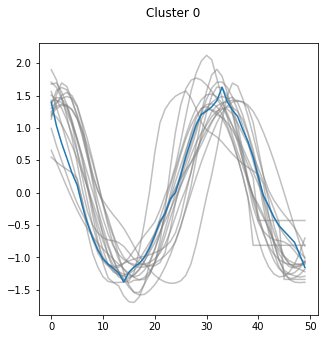

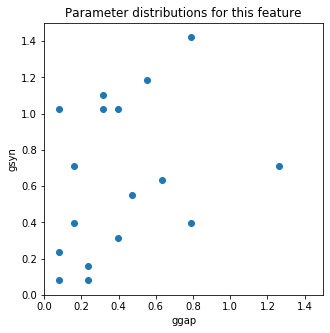

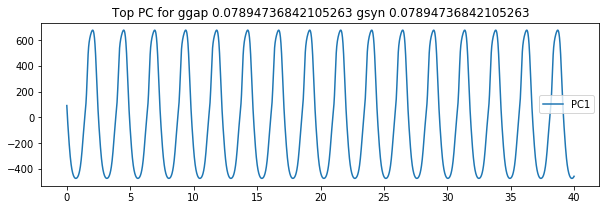

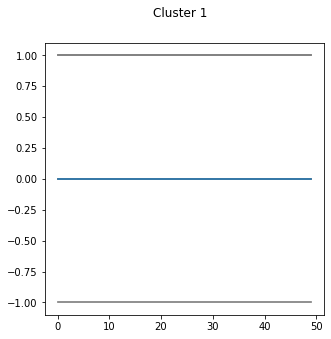

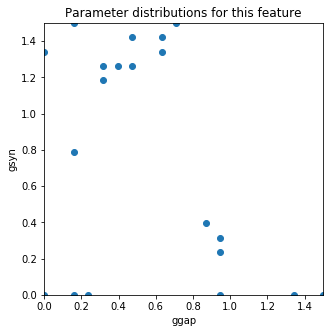

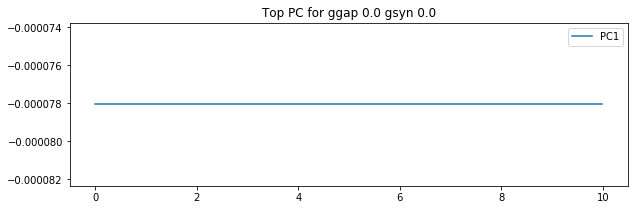

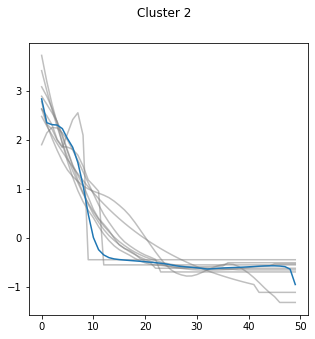

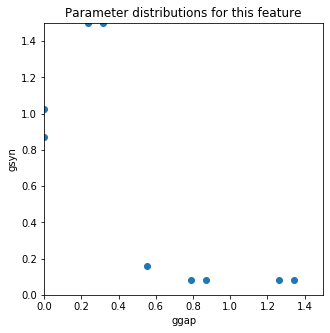

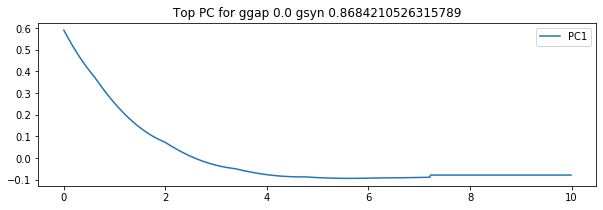

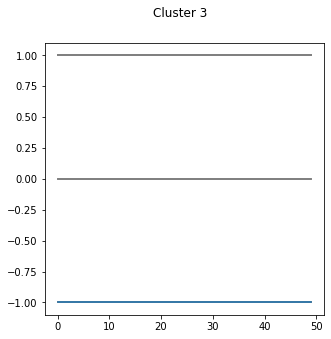

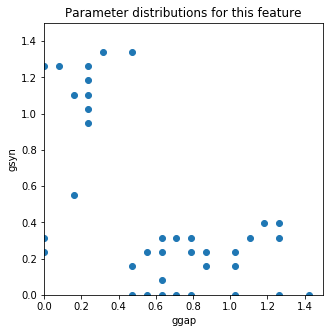

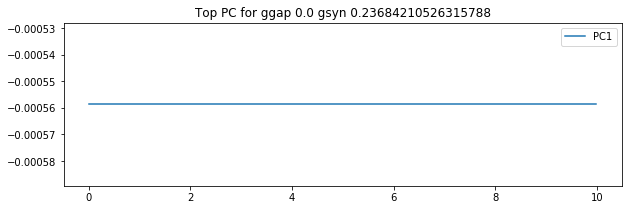

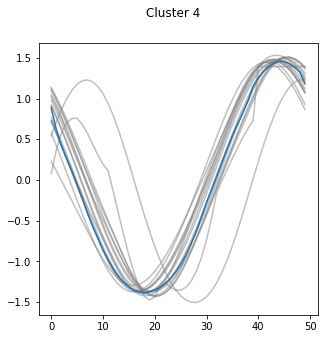

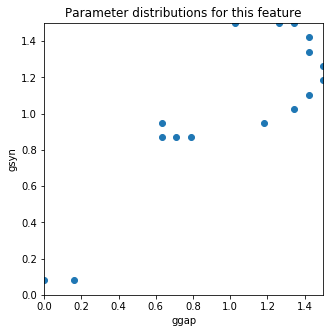

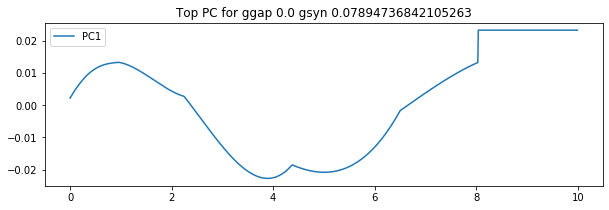

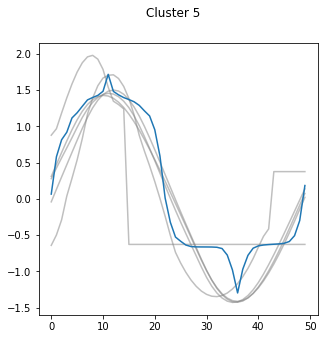

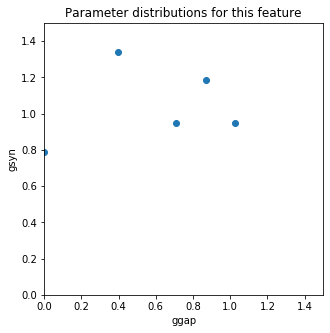

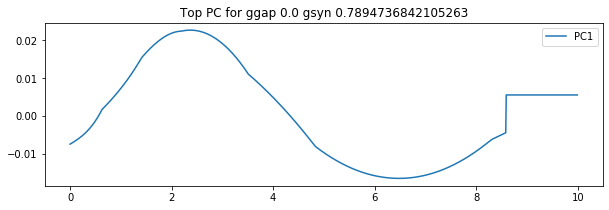

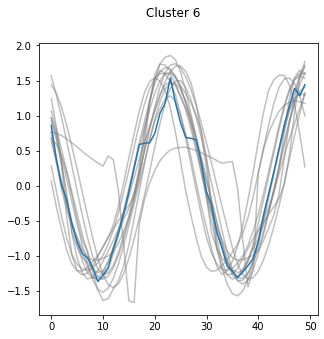

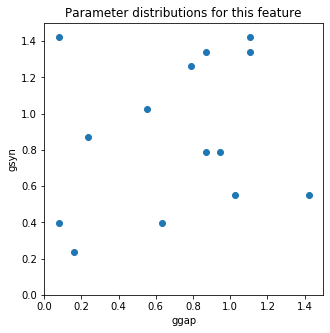

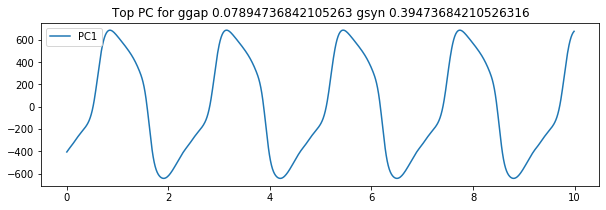

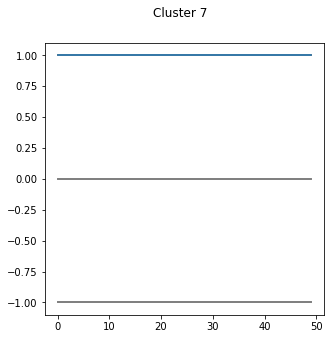

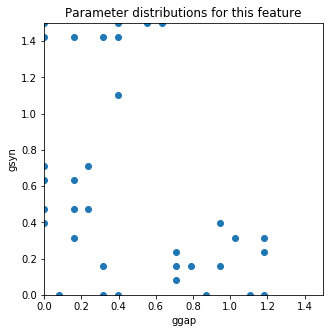

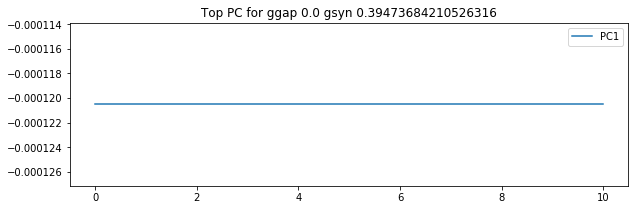

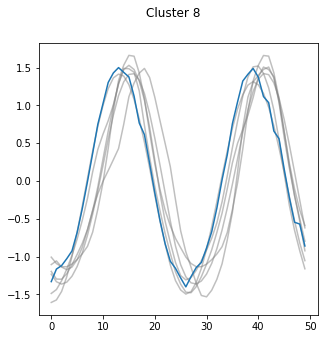

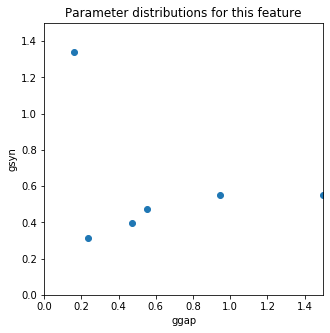

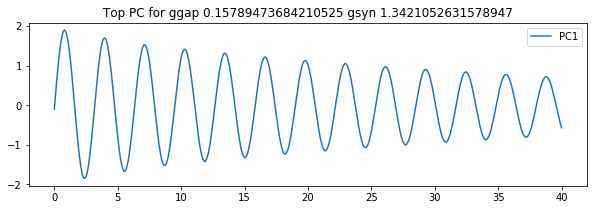

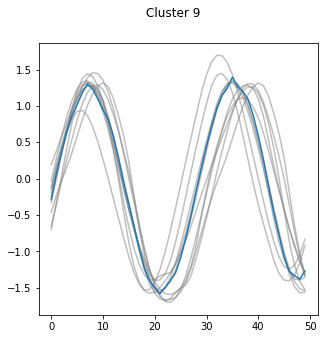

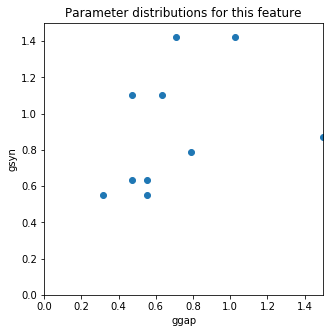

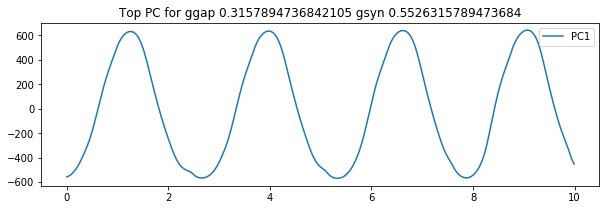

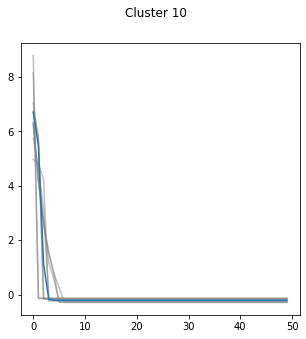

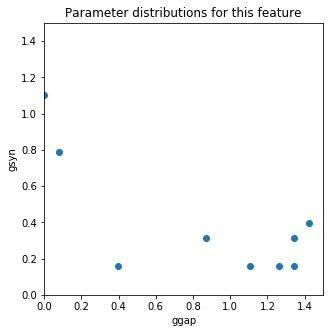

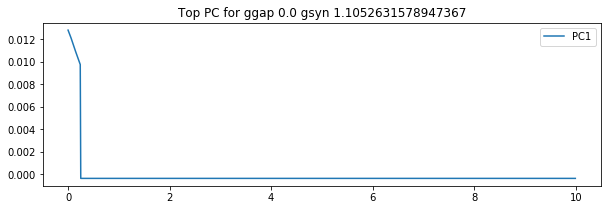

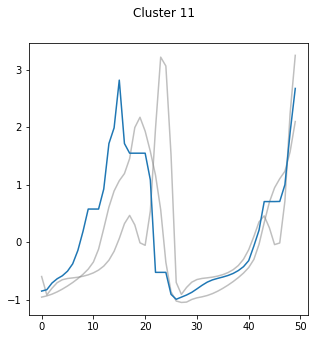

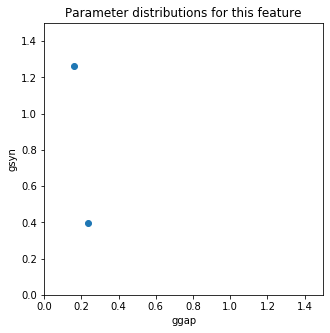

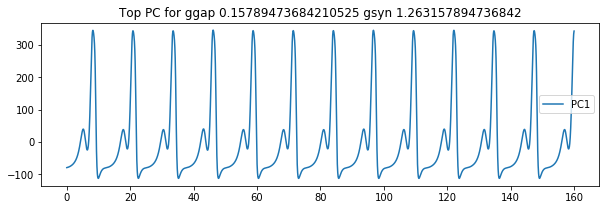

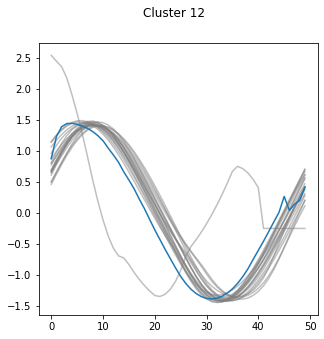

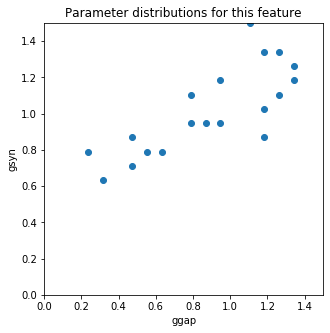

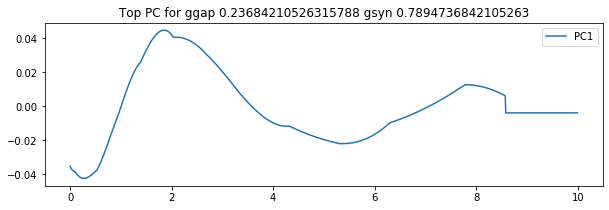

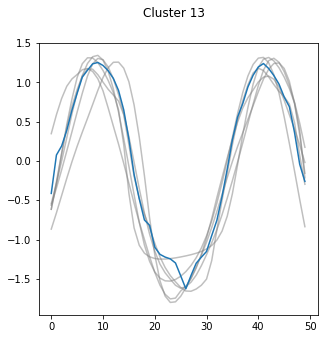

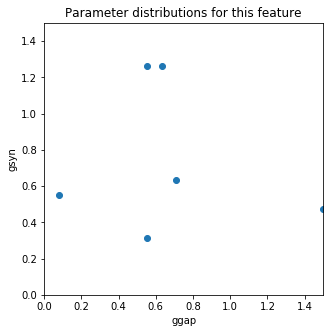

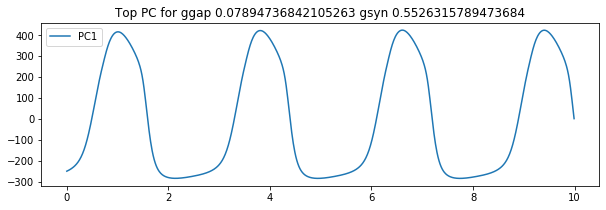

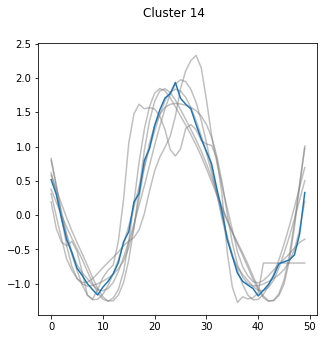

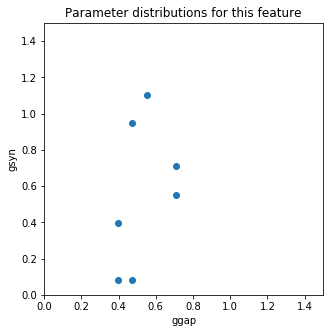

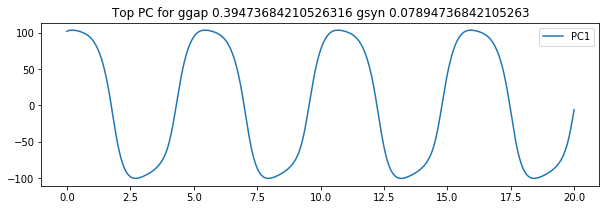

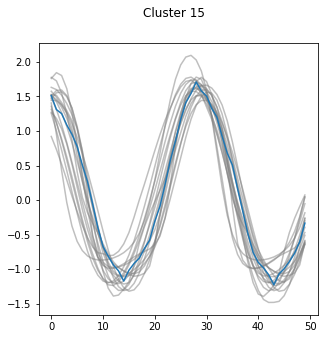

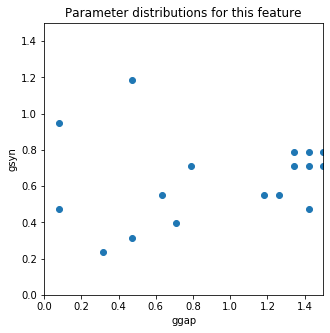

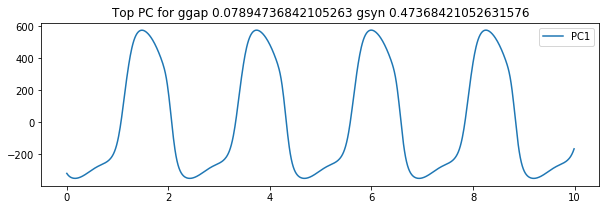

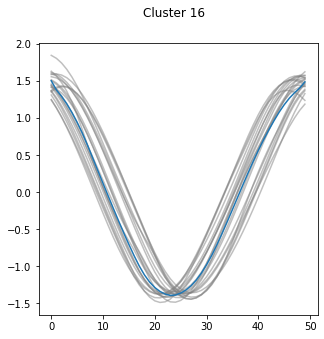

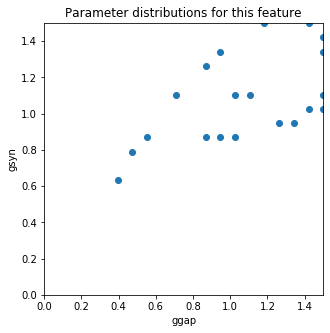

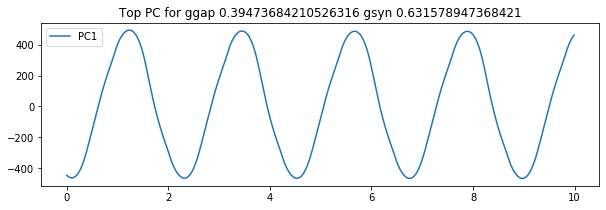

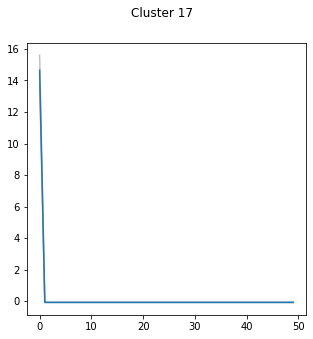

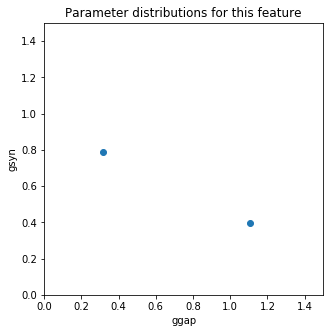

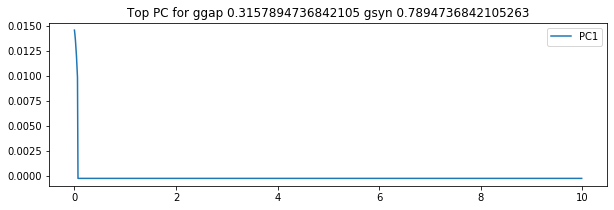

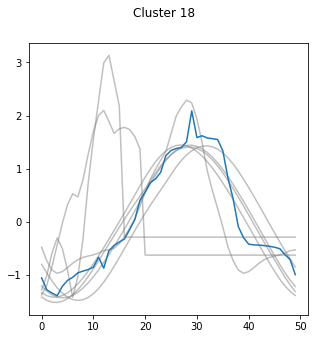

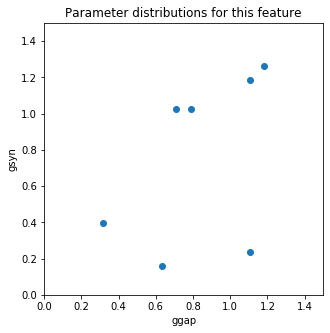

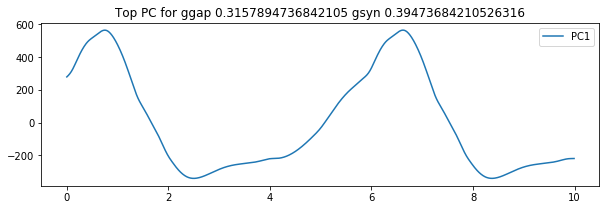

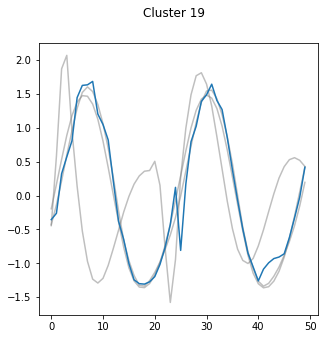

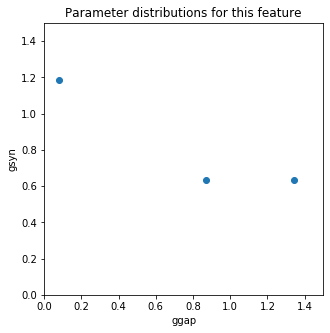

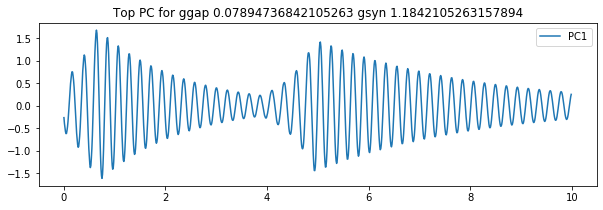

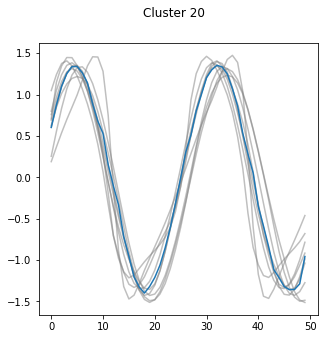

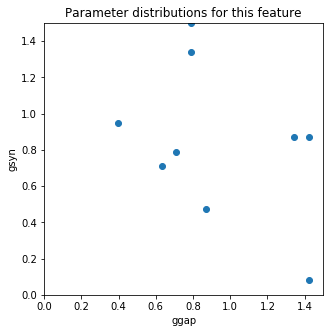

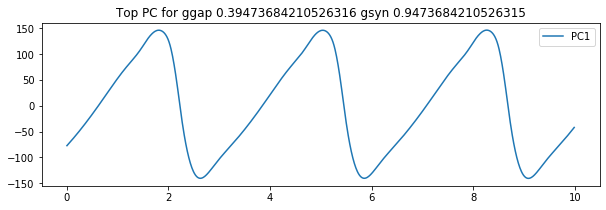

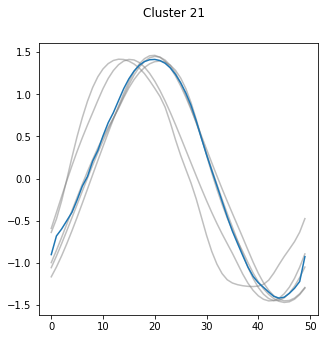

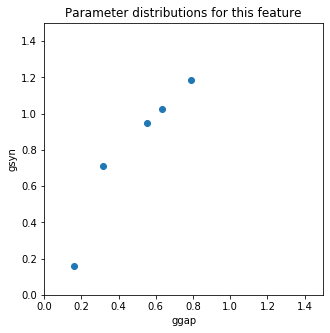

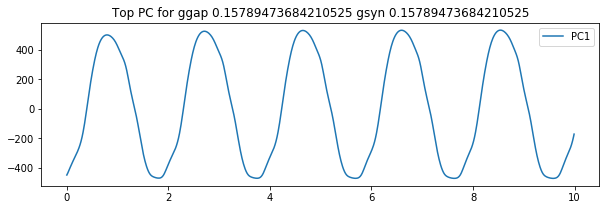

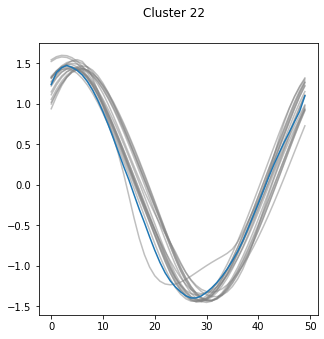

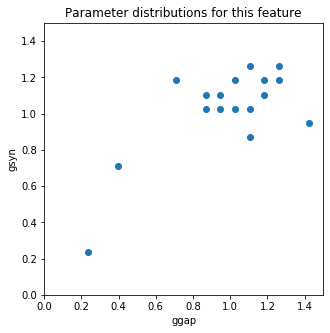

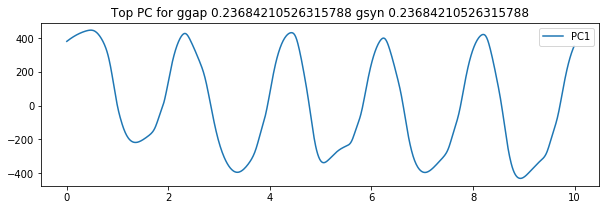

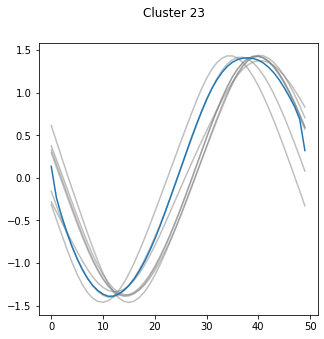

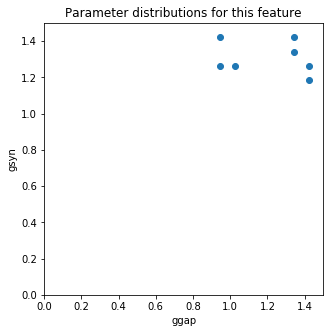

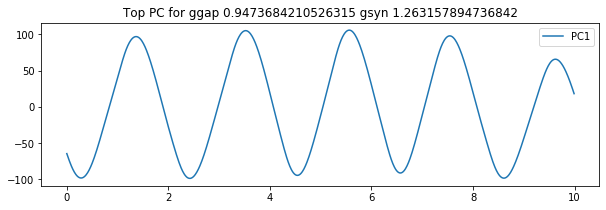

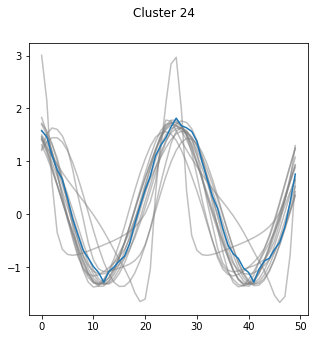

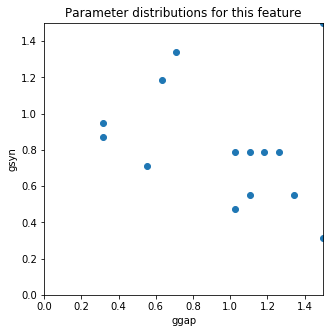

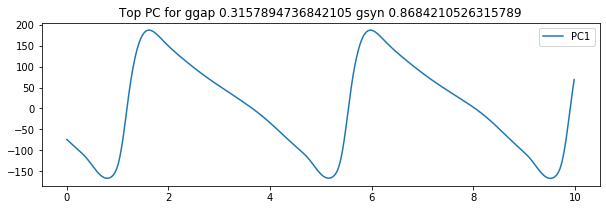

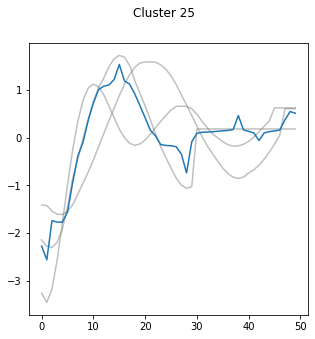

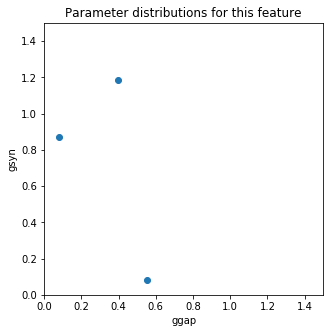

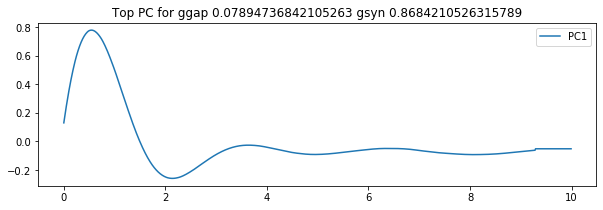

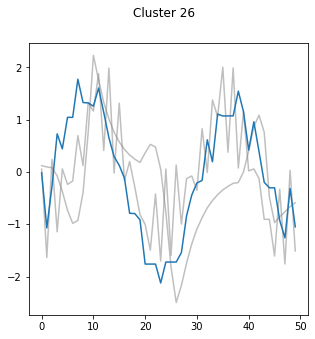

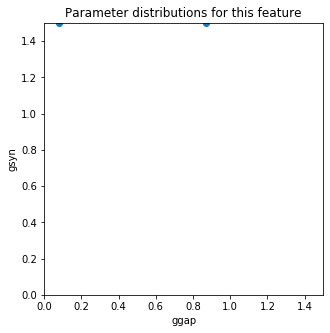

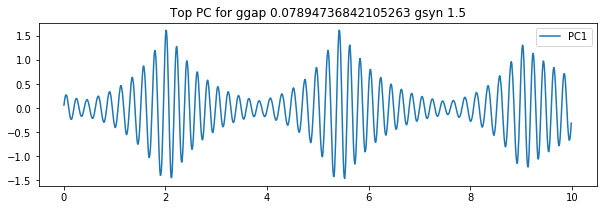

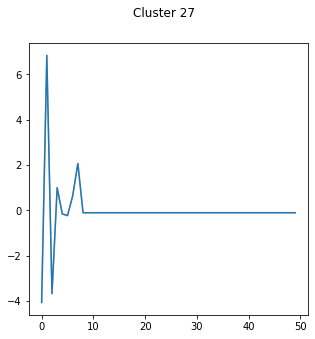

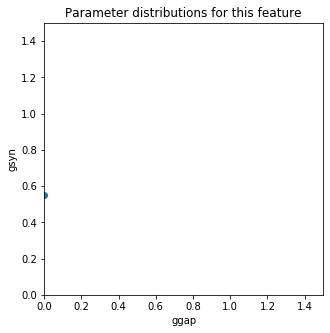

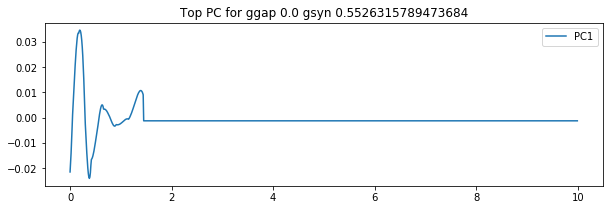

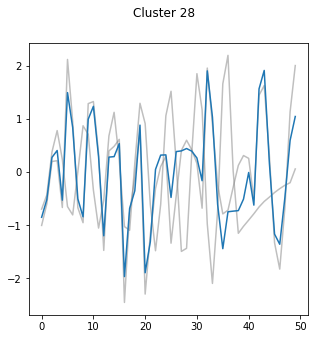

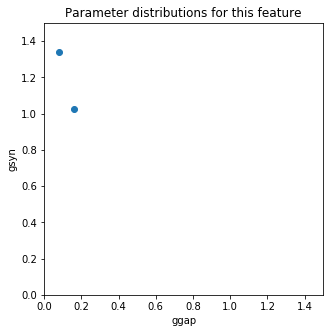

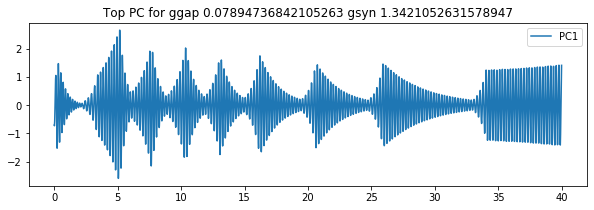

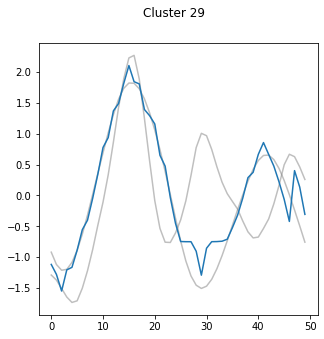

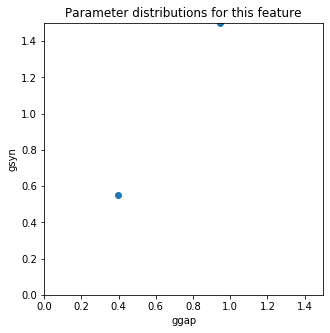

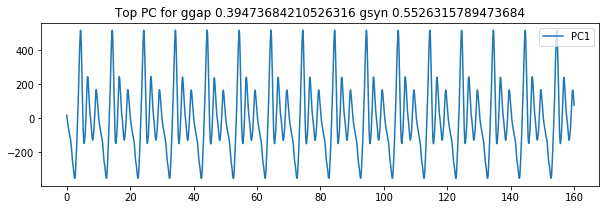

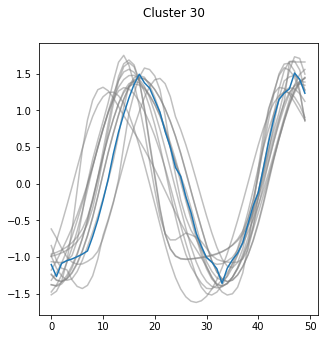

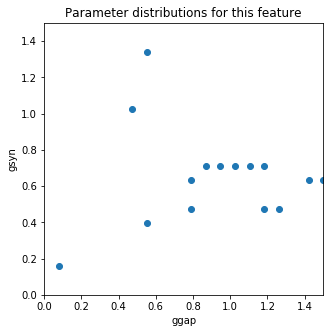

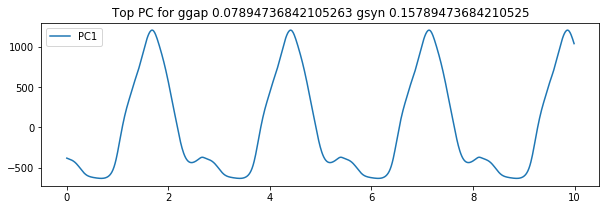

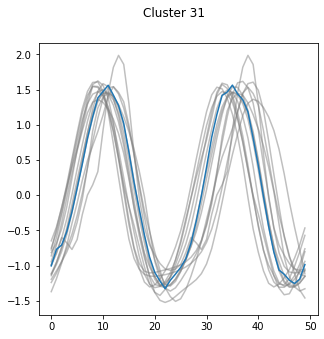

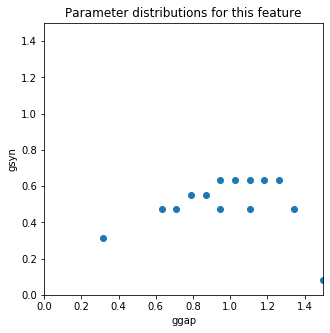

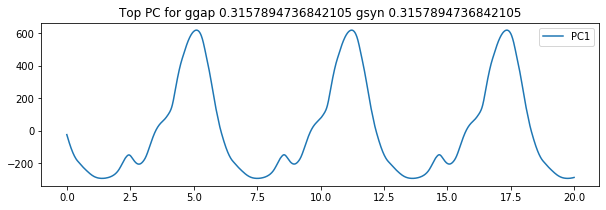

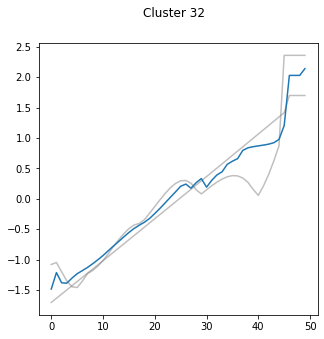

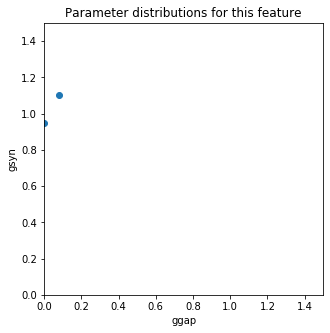

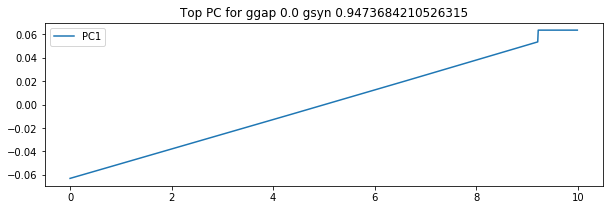

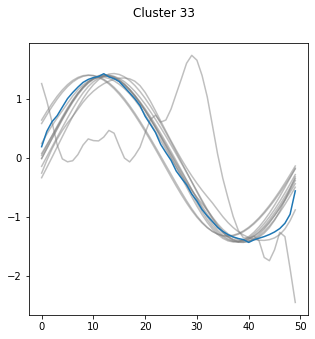

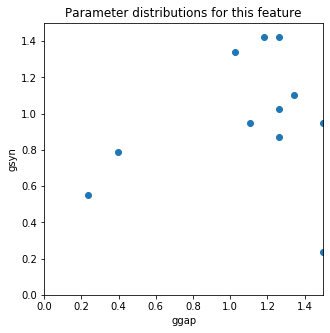

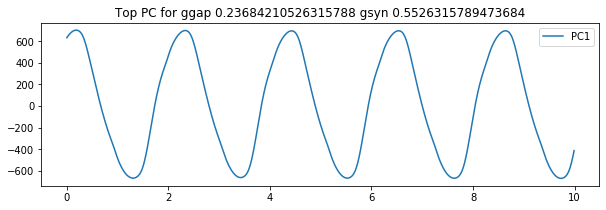

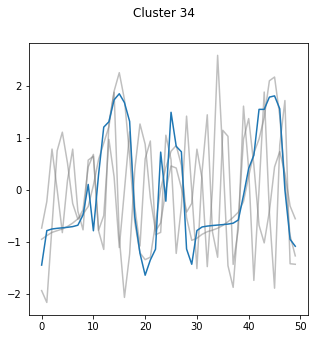

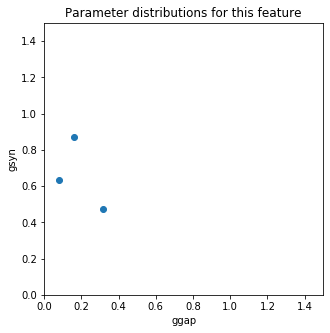

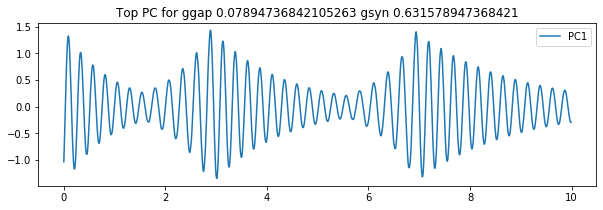

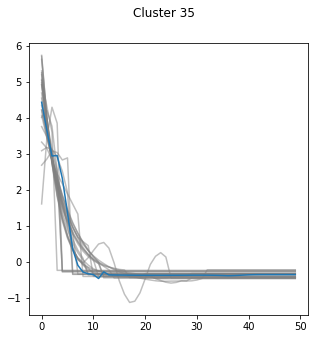

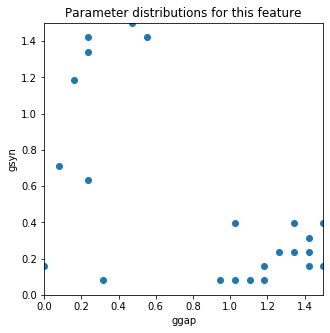

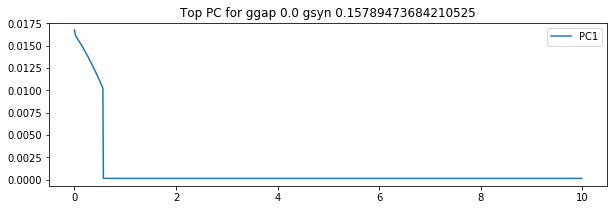

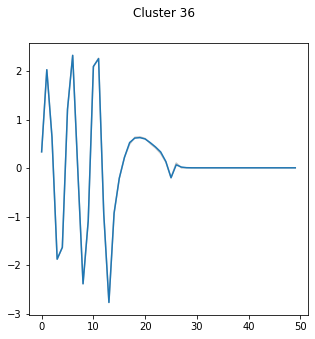

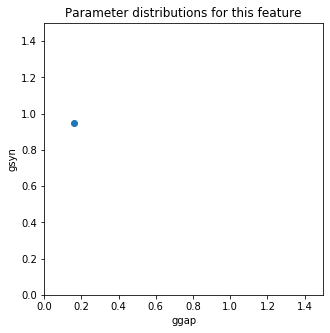

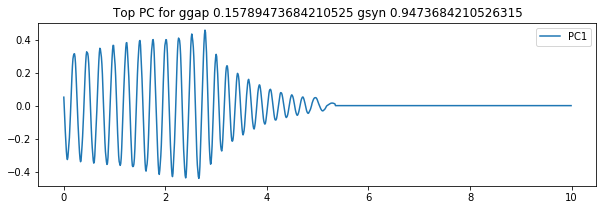

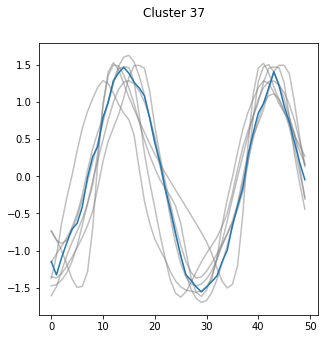

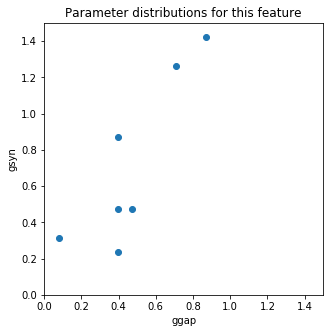

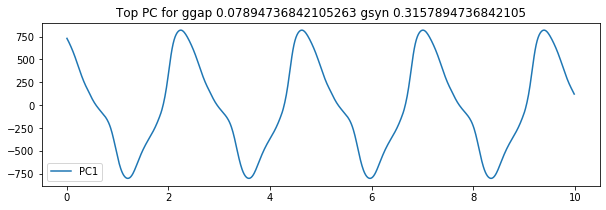

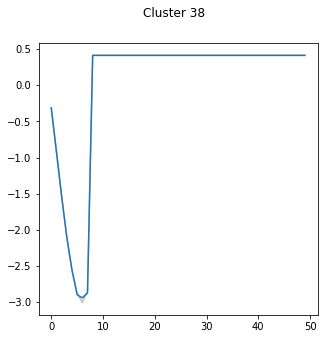

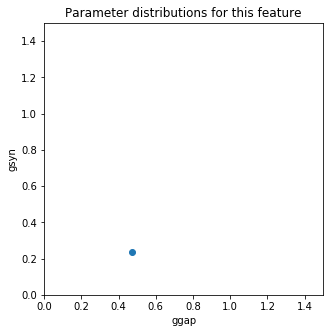

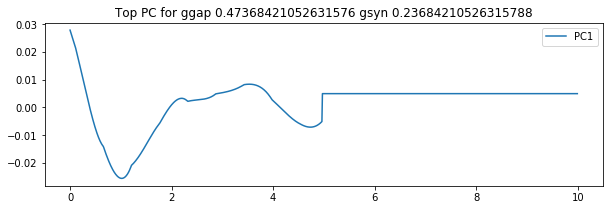

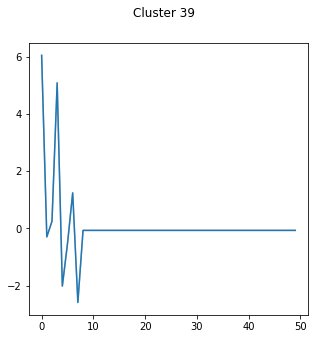

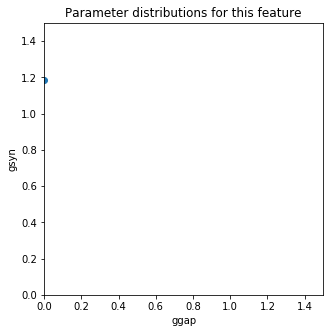

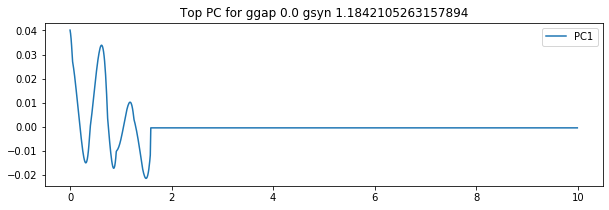

In [11]:
plot_cluster_results(cluster_labels, cluster_centers, None, params_list, ts_list)

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


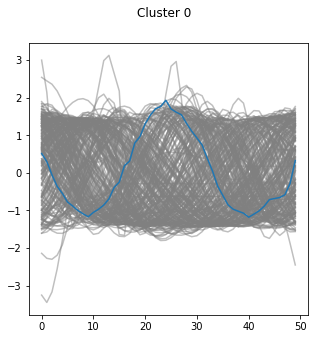

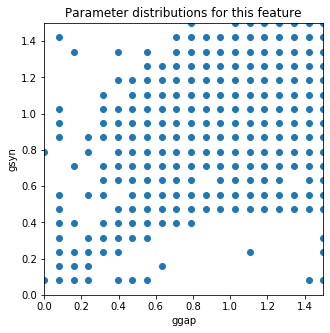

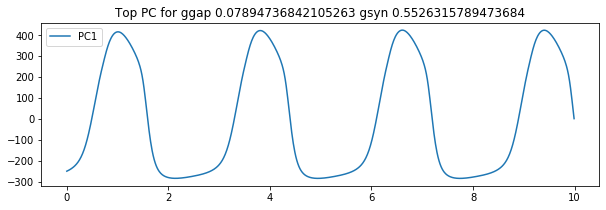

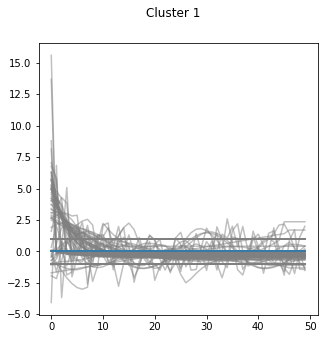

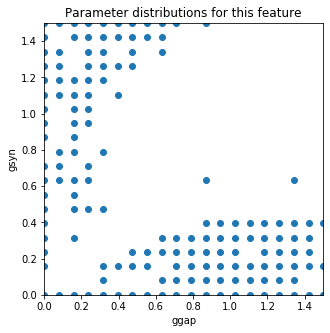

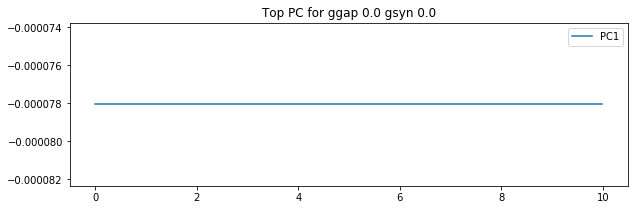

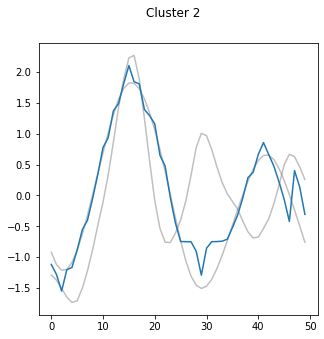

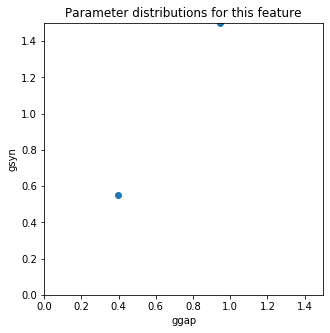

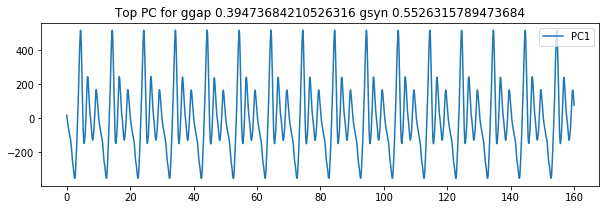

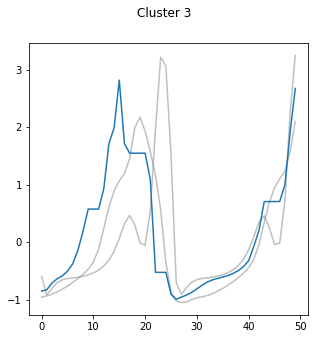

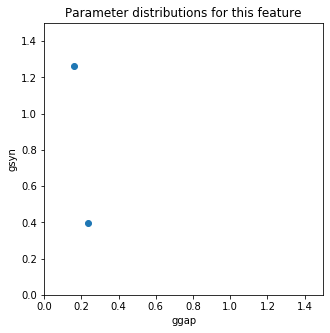

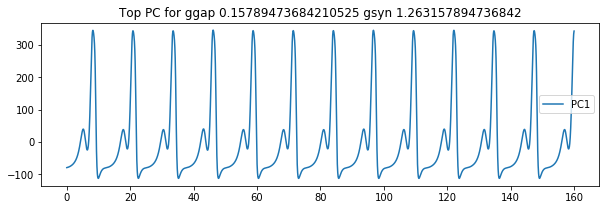

In [46]:
# Cluster the clusters manually by eyeballing.
# Oscillations [0, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 30, 31, 33, 37]
# Stable node [1, 3, 7, 38, 39, 2, 10, 17, 27, 32, 35, 36]
# Sharp oscillating amplitude [29]
# Spikes [11]

old_to_new_cluster_id = [0] * 40

new_clustering = \
  [[0, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 30, 31, 33, 37],
  [1, 3, 7, 38, 39, 2, 10, 17, 19, 26, 27, 28, 32, 34, 35, 36],
  [29],
  [11]]

cluster_id_to_sample_param_id = \
  [
    8,
    0,
    0,
    0
  ]

for new_cluster_id in range(len(new_clustering)):
  old_cluster_ids = new_clustering[new_cluster_id]
  for old_cluster_id in old_cluster_ids:
    old_to_new_cluster_id[old_cluster_id] = new_cluster_id

manual_cluster_labels = [0] * len(cluster_labels)
for i in range(len(cluster_labels)):
  manual_cluster_labels[i] = old_to_new_cluster_id[cluster_labels[i]]
manual_cluster_labels = np.array(manual_cluster_labels)

manual_cluster_centers = [0] * len(new_clustering)
for new_cluster_id in range(len(manual_cluster_centers)):
  sample_old_cluster_id = new_clustering[new_cluster_id][cluster_id_to_sample_param_id[new_cluster_id]]
  manual_cluster_centers[new_cluster_id] = cluster_centers[sample_old_cluster_id]
plot_cluster_results(manual_cluster_labels, manual_cluster_centers, cluster_id_to_sample_param_id,
                     params_list, ts_list)

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0


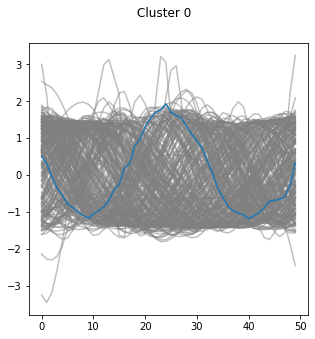

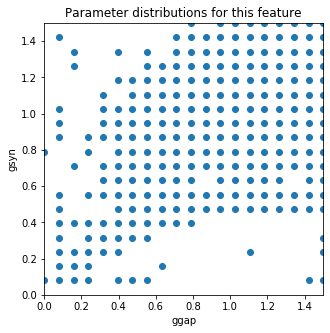

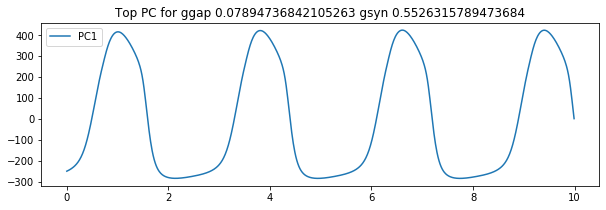

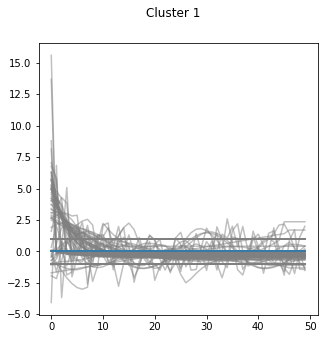

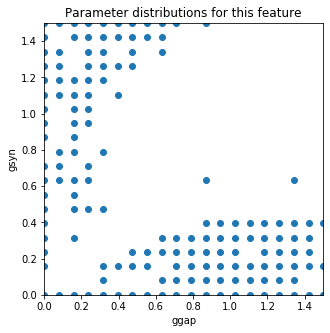

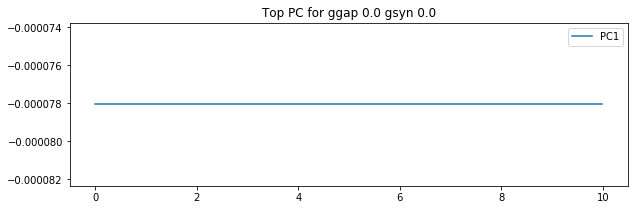

In [47]:
# Cluster the clusters to: stable vs non-zero amplitude, removing outliers
# Oscillations [0, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 30, 31, 33, 37]
# Strange behavior: amplitude keeps changing in no regular pattern [28]
# Stable node [1, 3, 7, 38, 39, 2, 10, 17, 27, 32, 35, 36]
# Stable focus [8]
# Sharp oscillating amplitude [29]
# Oscillating amplitude [19, 26, 34]
# Spikes [11]
old_to_new_cluster_id = [0] * 40

new_clustering = \
  [[0, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 30, 31, 33, 37,
    29, 8, 29, 11],
   [1, 3, 7, 38, 39, 2, 10, 17, 27, 32, 35, 36, 28, 19, 26, 34]]

cluster_id_to_sample_param_id = \
  [
    8,
    0
  ]

for new_cluster_id in range(len(new_clustering)):
  old_cluster_ids = new_clustering[new_cluster_id]
  for old_cluster_id in old_cluster_ids:
    old_to_new_cluster_id[old_cluster_id] = new_cluster_id

manual_cluster_labels = [0] * len(cluster_labels)
for i in range(len(cluster_labels)):
  manual_cluster_labels[i] = old_to_new_cluster_id[cluster_labels[i]]
manual_cluster_labels = np.array(manual_cluster_labels)

manual_cluster_centers = [0] * len(new_clustering)
for new_cluster_id in range(len(manual_cluster_centers)):
  sample_old_cluster_id = new_clustering[new_cluster_id][cluster_id_to_sample_param_id[new_cluster_id]]
  manual_cluster_centers[new_cluster_id] = cluster_centers[sample_old_cluster_id]
plot_cluster_results(manual_cluster_labels, manual_cluster_centers, cluster_id_to_sample_param_id,
                     params_list, ts_list)